In [1]:
# install required packages
!pip install nltk==3.2.5
!python -m nltk.downloader stopwords
!python -m nltk.downloader punkt
!python -m nltk.downloader wordnet
!pip install imbalanced-learn==0.8.1
!pip install pandas==1.3.5
!pip install matplotlib==3.2.2
!pip install seaborn==0.11.2
!pip install scikit-learn==1.0.2
!pip install tensorflow==2.8.0


/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# import required packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
nltk.download("punkt")
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# mounting google drive to read data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pd_data = pd.read_csv("/content/drive/MyDrive/sample30.csv")

## **EDA for data-**
1. Inspect the provided dataset for given columns, identify columns of interest
2. Check for missing values in columns and impute where possible
3. Graphs to understand data distributions

In [5]:
pd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [6]:
# selecting columns of interest for sentiment analysis and recommendation system
pd_data = pd_data[['id', 'name', 'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_username', 'user_sentiment']]
pd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                30000 non-null  object
 1   name              30000 non-null  object
 2   reviews_rating    30000 non-null  int64 
 3   reviews_text      30000 non-null  object
 4   reviews_title     29810 non-null  object
 5   reviews_username  29937 non-null  object
 6   user_sentiment    29999 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


In [7]:
# observations-
# 1. product id, product name and reviews ratings are available for all the rows
# 2. For sentiment analysis, we may drop the only row with missing user sentiment since the count is only 1
# 3. For recommendation system, we may drop rows where username is missing or if there are any duplicates on user, productid and reviews rating
# 4. reviews_title is missing for 190 rows, we may impute it with blank string

pd_sentiment = pd_data[['reviews_text', 'reviews_title', 'user_sentiment']]
pd_recommendation = pd_data[['id', 'reviews_rating', 'reviews_username']]

### EDA for data for sentiment analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviews_text    30000 non-null  object
 1   reviews_title   29810 non-null  object
 2   user_sentiment  29999 non-null  object
dtypes: object(3)
memory usage: 703.2+ KB
None
filling missing values for reviews_text with blank string

removing row with missing user sentiment

dataframe after cleaning and imputation

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviews_text    29999 non-null  object
 1   reviews_title   29999 non-null  object
 2   user_sentiment  29999 non-null  object
dtypes: object(3)
memory usage: 937.5+ KB
None


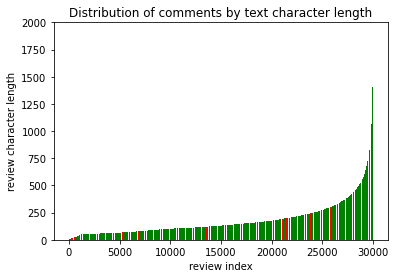

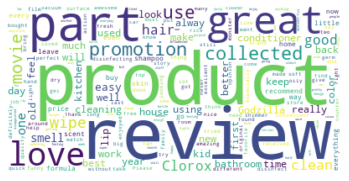


Top Trigrams in Text - 
{'as part of': 8778, 'this review was': 8744, 'collected as part': 8743, 'part of promotion': 8743, 'review was collected': 8743, 'was collected as': 8743, 'easy to use': 1261, 'love this product': 651, 'to use and': 582, 'this product for': 478, 'clorox disinfecting wipes': 473, 'all the time': 421, 'this is the': 409, 'have been using': 401, 'received this product': 400, 'this product is': 392, 'the old formula': 374, 'clorox wipes are': 358, 'to clean up': 355, 'for testing purposes': 354, 'in the kitchen': 353, 'and easy to': 342, 'one of the': 337, 'love these wipes': 332, 'so easy to': 327, 'is the best': 325, 'love clorox wipes': 323, 'are my own': 320, 'this is great': 317}


In [8]:
print(pd_sentiment.info())

print("filling missing values for reviews_text with blank string\n")
pd_sentiment.reviews_title.fillna("", inplace=True)

print("removing row with missing user sentiment\n")
pd_sentiment.dropna(inplace=True)

print("dataframe after cleaning and imputation\n")
print(pd_sentiment.info())


#     Visualise the data according to the 'reviews_text' character length
#     Using a word cloud to see top frequency words among all the reviews
#     display the top trigrams in reviews text

pd_sentiment_len = pd_sentiment.copy()
pd_sentiment_len['reviews_text_len'] = pd_sentiment_len.reviews_text.apply(lambda x: len(x))
pd_sentiment_len['color'] = pd_sentiment_len.user_sentiment.apply(lambda x: 'green' if x == 'Positive' else 'red')

pd_sentiment_len = pd_sentiment_len.sort_values(['reviews_text_len']).reset_index()
_ = pd_sentiment_len.pop('index')
pd_sentiment_len.head()
plt.bar(pd_sentiment_len.index, pd_sentiment_len.reviews_text_len, color=pd_sentiment_len.color)
plt.title('Distribution of comments by text character length')
plt.xlabel('review index')
plt.ylabel('review character length')
plt.ylim([0, 2000])
plt.show()

from wordcloud import WordCloud

corpus = " ". join(pd_sentiment.reviews_text.to_list())

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(corpus)

plt.imshow(word_cloud, interpolation='bilinear')

plt.axis("off")
plt.show()

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(3, 3))   
cv_fit = cv.fit_transform(pd_sentiment.reviews_text)    
word_list = cv.get_feature_names()
count_list = np.asarray(cv_fit.sum(axis=0))[0]

dict_vocab = dict(zip(word_list, count_list))
print()
print("Top Trigrams in Text - ")
print({k: v for k, v in sorted(dict_vocab.items(), key=lambda item: item[1], reverse=True)[:29]})

Observations -
1. There is no clear relation between text length and sentiment
2. The string **"this review was collected as part of promotion"** is present in almost every review, and therefore would not be of any significance to the model, we may remove it from reviews_text

### EDA for data for Recommendation system data

In [9]:
#select columns of interest for recommendation system
pd_recomm_data = pd_data[['reviews_username','reviews_rating','id']]

In [10]:
print(pd_recomm_data.info())
print()
print("Removing rows where username is missing")
print()
pd_recomm_data.dropna(inplace=True)
print("Shape after data cleaning")
print(pd_recomm_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviews_username  29937 non-null  object
 1   reviews_rating    30000 non-null  int64 
 2   id                30000 non-null  object
dtypes: int64(1), object(2)
memory usage: 703.2+ KB
None

Removing rows where username is missing

Shape after data cleaning
(29937, 3)


In [11]:
#check for any duplicates at username, product id level for reviews_rating
print(pd_recomm_data.groupby(['id','reviews_username']).count().head())

print("Certainly there are duplicates present, we may remove the duplicate ratings")

#remove if there are any duplicate rows in data
print("Shape after duplicate removal")
pd_recomm_data.drop_duplicates(subset=['reviews_username', 'id'], keep='first', inplace=True)
print(pd_recomm_data.shape)



                                       reviews_rating
id                   reviews_username                
AV13O1A8GV-KLJ3akUyj joshua                         1
AV14LG0R-jtxr-f38QfS dorothy w                      2
AV16khLE-jtxr-f38VFn amanda                         1
                     ashley a                       1
                     beccagrl532                    1
Certainly there are duplicates present, we may remove the duplicate ratings
Shape after duplicate removal
(27588, 3)


**Now we have the two datsets ready for sentiment analysis and building recommendation engine, we will proceed to modeling phase**

# Model for Sentiment Analysis

In [12]:
#removing the string from reviews_text that repeats for almost all comments, as seen in EDA phase.
pd_sentiment['reviews_text'] = pd_sentiment.reviews_text.apply(lambda x : x.replace("This review was collected as part of a promotion", ""))
pd_nlp_data = pd_sentiment.copy()
pd_nlp_data.head()

,reviews_text,reviews_title,user_sentiment
0,i love this album. it's very good. more to the...,Just Awesome,Positive
1,Good flavor. .,Good,Positive
2,Good flavor.,Good,Positive
3,I read through the reviews on here before look...,Disappointed,Negative
4,My husband bought this gel for us. The gel cau...,Irritation,Negative


In [13]:
# combine reviews_text and reviews_title columns
pd_nlp_data['text'] = pd_nlp_data.apply(lambda x: str(x['reviews_text']) + ' ' + str(x['reviews_title']), axis=1)
pd_nlp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29999 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviews_text    29999 non-null  object
 1   reviews_title   29999 non-null  object
 2   user_sentiment  29999 non-null  object
 3   text            29999 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


We are going to evaluate the solutions for classification problem of sentiment analysis on the review text in two ways

**1. Machine Learning-**
  *   Text Cleaning
  *   Class imbalance check and fix
  *   TF-IDF based feature creation
  *   Multiple classifiers to train
  *   Evaluate performance of each classifier
      *  **Model 1 - Logistic Regression**
      *  **Model 2 - Naive Bayes**
      *  **Model 3 - Random Forest with hyperparameter tuning**

**2. Deep Learning - Model 4**
  *   Text Cleaning
  *   Embeddings
  *   Attention Layer
  *   Evaluate performance of classifier

**1.1 Implementation Through Machine Learning**

In [14]:
# Feature Generation - preprocessing + tf-idf
# Steps
# 1.1 lower casing
# 1.2 punctuation removal
# 1.3 stop word removal
# 1.4 Stemming
# 1.5 Lemmatization
# 1.6 TF-IDF creation

tokenizer = nltk.RegexpTokenizer(r"\w+")
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text_method1(text):
    text = text.lower()
    text = tokenizer.tokenize(text)
    text = [x for x in text if x not in stop_words]
    text = [ps.stem(x) for x in text]
    text = [lemmatizer.lemmatize(x) for x in text]
    return " ".join(text)

In [15]:
pd_nlp_data['text_clean'] = pd_nlp_data.text.apply(clean_text_method1)
    
pd_nlp_data.head()

,reviews_text,reviews_title,user_sentiment,text,text_clean
0,i love this album. it's very good. more to the...,Just Awesome,Positive,i love this album. it's very good. more to the...,love album good hip hop side current pop sound...
1,Good flavor. .,Good,Positive,Good flavor. . Good,good flavor good
2,Good flavor.,Good,Positive,Good flavor. Good,good flavor good
3,I read through the reviews on here before look...,Disappointed,Negative,I read through the reviews on here before look...,read review look buy one coupl lubric ultim di...
4,My husband bought this gel for us. The gel cau...,Irritation,Negative,My husband bought this gel for us. The gel cau...,husband bought gel u gel caus irrit felt like ...


In [16]:
pd_nlp_data = pd_nlp_data[['text_clean' , 'user_sentiment']]

In [17]:
# apply train test split on data
X = pd_nlp_data.text_clean
y = pd_nlp_data.user_sentiment

y = y.apply(lambda x: 1 if x=='Positive' else 0) # convert target classes to binary 0 and 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("Training data shape = X = {}, y= {}".format(X_train.shape, y_train.shape))
print("Testing data shape = X = {}, y= {}".format(X_test.shape, y_test.shape))

Training data shape = X = (20099,), y= (20099,)
Testing data shape = X = (9900,), y= (9900,)


In [18]:
# generate TFIDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [19]:
print("X_train has {} training rows of {} columns".format(X_train_tfidf.shape[0], X_train_tfidf.shape[1]))
print("X_test has {} testing rows of {} columns".format(X_test_tfidf.shape[0], X_test_tfidf.shape[1]))

X_train has 20099 training rows of 10629 columns
X_test has 9900 testing rows of 10629 columns


In [20]:
# check for class imbalance in training sample
y_train.value_counts(normalize=True)

1    0.886213
0    0.113787
Name: user_sentiment, dtype: float64

### **Handling class imbalance through oversampling with SMOTE**

In [21]:
#oversampling through SMOTE to make balanced class distribution

from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train_bal, y_train_bal = oversample.fit_resample(X_train_tfidf, y_train)
print("Balance after SMOTE processing")
y_train_bal.value_counts(normalize=True)

Balance after SMOTE processing


1    0.5
0    0.5
Name: user_sentiment, dtype: float64

In [22]:
# we will try multiple ML modeling techniques with hyperparameter tuning over this data 
# model 1 - Logistic regression
# model 2 - Naive Bayes
# model 3 - Random Forest

def lr_model():
  clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train_bal, y_train_bal)
  return clf

clf_lr = lr_model()

def nb_model():
  clf = MultinomialNB()
  clf.fit(X_train_bal, y_train_bal)
  return clf

clf_nb = nb_model()

In [51]:
def evalModel(X_tr, y_tr, X_tes, y_tes, model, batch_size=None):
  if batch_size is None:
    y_tr_pred = model.predict(X_tr)
    y_tes_pred = model.predict(X_tes)
  else:
    y_tr_pred = model.predict(X_tr, batch_size = batch_size)
    y_tr_pred = [1 if x >= 0.6 else 0 for x in y_tr_pred]
    y_tes_pred = model.predict(X_tes, batch_size = batch_size)
    y_tes_pred = [1 if x >= 0.6 else 0 for x in y_tes_pred]

  tn, fp, fn, tp = metrics.confusion_matrix(y_tr, y_tr_pred).ravel()
  specificity = tn / (tn+fp)
  senstivity = tp / (tp+fn)
  auc = metrics.roc_auc_score(y_tr, y_tr_pred)

  print("Training specificity = {}".format(specificity))
  print("Training senstivity = {}".format(senstivity))
  print("Training AUC = {}\n".format(auc))

  tn, fp, fn, tp = metrics.confusion_matrix(y_tes, y_tes_pred).ravel()
  specificity = tn / (tn+fp)
  senstivity = tp / (tp+fn)
  auc = metrics.roc_auc_score(y_tes, y_tes_pred)

  print("Testing specificity = {}".format(specificity))
  print("Testing senstivity = {}".format(senstivity))
  print("Testing AUC = {}".format(auc))

In [24]:
print("Evaluation for Logistic Regression Model")
evalModel(X_train_bal, y_train_bal, X_test_tfidf, y_test, clf_lr)

Evaluation for Logistic Regression Model
Training specificity = 0.9486862789130923
Training senstivity = 0.8871547271502358
Training AUC = 0.9179205030316642

Testing specificity = 0.7675925925925926
Testing senstivity = 0.8787981859410431
Testing AUC = 0.8231953892668179


In [25]:
print("Evaluation for Naive bayes Classifier Model")
evalModel(X_train_bal, y_train_bal, X_test_tfidf, y_test, clf_nb)

Evaluation for Naive bayes Classifier Model
Training specificity = 0.8569503705367169
Training senstivity = 0.8663260723108017
Training AUC = 0.8616382214237593

Testing specificity = 0.5879629629629629
Testing senstivity = 0.8476190476190476
Testing AUC = 0.7177910052910054


In [26]:
def rf_model():
  # Number of trees in random forest
  n_estimators = [int(x) for x in np.linspace(start = 5, stop = 200, num = 10)]
  # Maximum number of levels in tree
  max_depth = range(50, 100, 10)
  # Minimum number of samples required to split a node
  min_samples_split = [2, 5, 10]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [5, 7, 10]
  # Create the random grid
  random_grid = {'n_estimators': n_estimators,
                 'max_depth': max_depth,
                 'min_samples_split': min_samples_split,
                 'min_samples_leaf': min_samples_leaf,
                }
  print(random_grid)
  rf = RandomForestClassifier(random_state = 42)
  rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=1, random_state=42, n_jobs = -1)
  
  # Fit the random search model
  rf_random.fit(X_train_bal, y_train_bal)

  # get the best fit parameter
  best_fit = rf_random.best_params_

  #fit model on best parameters
  clf = RandomForestClassifier(random_state = 42, max_depth = best_fit['max_depth'], min_samples_leaf = best_fit['min_samples_leaf'], min_samples_split=best_fit['min_samples_split'], n_estimators=best_fit['n_estimators'])
  clf.fit(X_train_bal, y_train_bal)
  return clf

rf_clf = rf_model()

{'n_estimators': [5, 26, 48, 70, 91, 113, 135, 156, 178, 200], 'max_depth': range(50, 100, 10), 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [5, 7, 10]}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [27]:
print("Evaluation for Random Forest Classifier Model")
evalModel(X_train_bal, y_train_bal, X_test_tfidf, y_test, rf_clf)

Evaluation for Random Forest Classifier Model
Training specificity = 0.9261172243431395
Training senstivity = 0.9470581630361554
Training AUC = 0.9365876936896474

Testing specificity = 0.5046296296296297
Testing senstivity = 0.9165532879818594
Testing AUC = 0.7105914588057445


### **2. Implementation Through Deep Learning**

In [28]:
pd_nlp_data = pd_sentiment.copy()
pd_nlp_data['text'] = pd_nlp_data.apply(lambda x: str(x['reviews_text']) + ' ' + str(x['reviews_title']), axis=1)
pd_nlp_data.head()

,reviews_text,reviews_title,user_sentiment,text
0,i love this album. it's very good. more to the...,Just Awesome,Positive,i love this album. it's very good. more to the...
1,Good flavor. .,Good,Positive,Good flavor. . Good
2,Good flavor.,Good,Positive,Good flavor. Good
3,I read through the reviews on here before look...,Disappointed,Negative,I read through the reviews on here before look...
4,My husband bought this gel for us. The gel cau...,Irritation,Negative,My husband bought this gel for us. The gel cau...


In [29]:
# For deep learning based model we would do minimum preprocessing and would let the model learn from word2vec about contextual information of the text
X = pd_nlp_data['text'].apply(lambda x : re.sub("[^a-z ]","", x.lower()).replace("  "," ")) # convert to lowercase, remove special chars and any consecutive white spaces.
y = pd_nlp_data['user_sentiment'].apply(lambda x : 1 if x=='Positive' else 0).astype('float') # convert target classes to binary 0 and 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # apply train test split
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(20099,) (20099,)
(9900,) (9900,)


In [30]:
vocab_size  = 10000
pad_id = 0
start_id = 1
oov_id = 2
index_offset = 2

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_id)
tokenizer.fit_on_texts(X_train)

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train)

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])

# Pad the training sequences
train_padded = pad_sequences(train_sequences, truncating='post', padding='post', value=pad_id, maxlen=maxlen)

In [31]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, truncating='post', padding='post', value=pad_id, maxlen=maxlen)

In [32]:
class CustomAttention(tf.keras.Model):
    def __init__(self, units):
        super(CustomAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [33]:
rnn_cell_size = 32

sequence_input = tf.keras.layers.Input(shape=(maxlen,), dtype='int32')
embedded_sequences = tf.keras.layers.Embedding(vocab_size, 128, input_length=maxlen)(sequence_input)

lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_cell_size, dropout=0.8, return_sequences=True, return_state=True))(embedded_sequences)
lstm, forward_h, forward_c, backward_h, backward_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_cell_size, dropout=0.7, return_sequences=True, return_state=True))(lstm)                                 


In [34]:
state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

context_vector, attention_weights = CustomAttention(10)(lstm, state_h)

output = tf.keras.layers.Dense(1, activation='sigmoid')(context_vector)

model = tf.keras.Model(inputs=sequence_input, outputs=output)

# summarize layers
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 575)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 575, 128)     1280000     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  [(None, 575, 64),    41216       ['embedding[0][0]']              
                                 (None, 32),                                                      
                                 (None, 32),                                                      
                                 (None, 32),                                                  

In [35]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        min_delta=0,
                                                        patience=3,
                                                        verbose=0, mode='auto')


In [36]:
epochs=20
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', tf.keras.metrics.AUC()])

In [37]:
class_weight = {0: 9.,
                1: 1.}
history = model.fit(train_padded, \
                      y_train, \
                      epochs=epochs, \
                      batch_size=500, \
                      validation_data=(test_padded, y_test), \
                      verbose=1, \
                      callbacks = [early_stopping_callback], \
                      class_weight=class_weight
                    
                    )


Epoch 1/20
41/41 [==============================] - 355s 8s/step - loss: 1.3190 - acc: 0.1180 - auc: 0.5089 - val_loss: 0.7559 - val_acc: 0.1102 - val_auc: 0.6277
Epoch 2/20
41/41 [==============================] - 347s 8s/step - loss: 1.0363 - acc: 0.6037 - auc: 0.7977 - val_loss: 0.4530 - val_acc: 0.7904 - val_auc: 0.9087
Epoch 3/20
41/41 [==============================] - 344s 8s/step - loss: 0.6319 - acc: 0.8449 - auc: 0.9307 - val_loss: 0.3173 - val_acc: 0.8753 - val_auc: 0.9288
Epoch 4/20
41/41 [==============================] - 345s 8s/step - loss: 0.4797 - acc: 0.8832 - auc: 0.9594 - val_loss: 0.2509 - val_acc: 0.8996 - val_auc: 0.9349
Epoch 5/20
41/41 [==============================] - 348s 8s/step - loss: 0.4040 - acc: 0.9031 - auc: 0.9704 - val_loss: 0.2218 - val_acc: 0.9127 - val_auc: 0.9398
Epoch 6/20
41/41 [==============================] - 341s 8s/step - loss: 0.3427 - acc: 0.9228 - auc: 0.9777 - val_loss: 0.2780 - val_acc: 0.8969 - val_auc: 0.9382
Epoch 7/20
41/41 [====

In [52]:
# y_test_pred = model.predict(test_padded, batch_size=512)
print("Evaluation for Deep learning Classifier Model")
evalModel(train_padded, y_train, test_padded, y_test, model, batch_size=5000)

Evaluation for Deep learning Classifier Model
Training specificity = 0.9943156974202011
Training senstivity = 0.966763979339771
Training AUC = 0.980539838379986

Testing specificity = 0.7638888888888888
Testing senstivity = 0.9365079365079365
Testing AUC = 0.8501984126984127


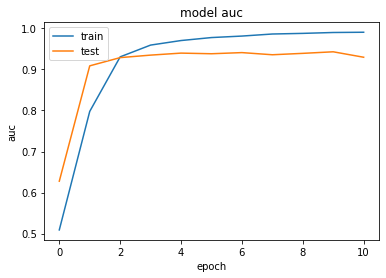

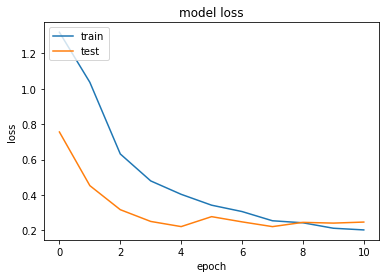

In [53]:
import matplotlib.pyplot as plt
import numpy
auc_key = [x for x in history.history.keys() if 'auc' in x and 'val' not in x][0]
# summarize history for accuracy
plt.plot(history.history[auc_key])
plt.plot(history.history['val_' + auc_key])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **Summary of 4 Models for sentiment analysis**
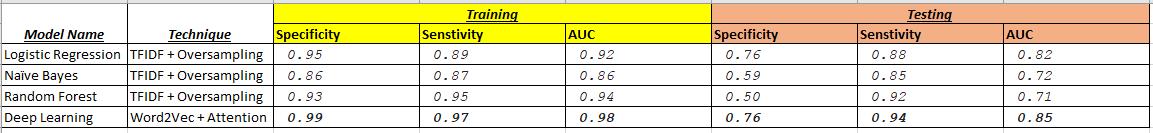

## ** ========Implementation of Recommendation System ==========**

In [40]:
# split the data into train-test
from sklearn.model_selection import train_test_split
train, test = train_test_split(pd_recomm_data, test_size=0.3, random_state=2)

**Implementing User-User based recommendation system**

In [41]:
# pivot the data to create a user vs. productid grid where each cell will represent the rating given by user to the product.
pd_pivot = train.pivot(index='reviews_username', columns='id', values='reviews_rating')

#display an example row in dataset
pd_pivot[~pd_pivot['AV13O1A8GV-KLJ3akUyj'].isna()].head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
joshua,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#normalizing ratings in trainind data for adjusted cosine calculation
mean = np.nanmean(pd_pivot, axis=1)
pd_subtracted = (pd_pivot.T-mean).T

In [43]:
# display an example row after normalization
pd_subtracted[~pd_subtracted['AV13O1A8GV-KLJ3akUyj'].isna()].head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,...,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
joshua,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# calculating user-user similarity matrix
from sklearn.metrics.pairwise import pairwise_distances

user_correlation = 1- pairwise_distances(pd_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0

#cap any negative values to zero
user_correlation[user_correlation<0]=0

#apply a dot product between similarity matrix and user rating data to predict user level product rating
user_predicted_ratings = np.dot(user_correlation, pd_pivot.fillna(0))

# create a dummy train data to have 0 as rating where user has given a rating else 1, this will help in predicting and testing the model for the products where user has not provided a product rating.
dummy_train = train.copy().fillna(0)
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)
dummy_train = dummy_train.pivot(index='reviews_username', columns='id', values='reviews_rating').fillna(1)

#multiply with dummy train to only get predicted ratings where user has not given a rating
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)

#print top5 recommendation results for a sample user
print(user_final_rating.loc['joshua'].sort_values(ascending=False)[0:5])

id
AVpe41TqilAPnD_xQH3d    5.782126
AVpf3VOfilAPnD_xjpun    5.771157
AVpf0eb2LJeJML43EVSt    5.258781
AVpfPaoqLJeJML435Xk9    4.475604
AVpe59io1cnluZ0-ZgDU    4.115405
Name: joshua, dtype: float64


In [45]:
#Evaluating the model
from sklearn.preprocessing import MinMaxScaler
from numpy import *

#for model evaluation we need common users between train and test, we will make predictions on train and calculate a rmse w.r.t actual ratings in test
common = test[test.reviews_username.isin(train.reviews_username)]
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

# converting similarity matrix to pandas dataframe and renaming columns as per user list
user_correlation_df = pd.DataFrame(user_correlation) 
user_correlation_df['reviews_username'] = pd_subtracted.index
user_correlation_df.set_index('reviews_username', inplace= True)
list_name = common.reviews_username.tolist()
user_correlation_df.columns = pd_subtracted.index.tolist()

#filter for only the common userids
user_correlation_df_1 = user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]
user_correlation_df_3 = user_correlation_df_2.T
user_correlation_df_3[user_correlation_df_3<0] = 0

#dot product to predict ratings
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x >=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings, dummy_test)

common_user_predicted_ratings_1 = common_user_predicted_ratings.copy()
common_user_predicted_ratings_1 = common_user_predicted_ratings_1[common_user_predicted_ratings_1>0]

#for a fair comparison since we have used adjusted cosines for similarity calculation, we
# also need to normalize it for the comparison data
scaler = MinMaxScaler(feature_range=(1,5))
scaler.fit(common_user_predicted_ratings_1)
common_user_predicted_ratings_norm = scaler.transform(common_user_predicted_ratings_1)

#calculate rmse for actual vs predicted rating in common data
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
total_non_nan = np.count_nonzero(~np.isnan(common_user_predicted_ratings_norm))
rmse  = (sum(sum((common_ - common_user_predicted_ratings_norm)**2))/total_non_nan)**0.5
print("RMSE for user-user based recommendation system = {}".format(rmse))


RMSE for user-user based recommendation system = 2.4749480007969487


**Implementing Item-Item based recommendation system**

In [46]:
# pivot the data to create a productid vs user grid where each cell will represent the rating given by user to the product.
pd_pivot = train.pivot(index='reviews_username', columns='id', values='reviews_rating').T
pd_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1085,10ten,11111111aaaaaaaaaaaaaaaaa,...,zozo0o,zsarah,zsazsa,zt313,zubb,zuttle,zwithanx,zxjki,zyiah4,zzdiane
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#normalizing ratings in trainind data for adjusted cosine calculation
mean = np.nanmean(pd_pivot, axis=1)
pd_subtracted = (pd_pivot.T-mean).T

In [48]:
# calculating item-item similarity matrix
from sklearn.metrics.pairwise import pairwise_distances

item_correlation = 1- pairwise_distances(pd_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0

#cap any negative values to zero
item_correlation[item_correlation<0]=0

#apply a dot product between similarity matrix and item rating data to predict item level rating
item_predicted_ratings = np.dot(pd_pivot.fillna(0).T, item_correlation)

# create a dummy train data to have 0 as rating where user has given a rating else 1, this will help in predicting and testing the model for the products where user has not provided a product rating.
dummy_train = train.copy().fillna(0)
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)
dummy_train = dummy_train.pivot(index='reviews_username', columns='id', values='reviews_rating').fillna(1)

#multiply with dummy train to only get predicted ratings where user has not given a rating
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)

#print top5 recommendation results for a sample user
print(item_final_rating.loc['joshua'].sort_values(ascending=False)[0:5])

id
AVpf5olc1cnluZ0-tPrO    0.222675
AVpe_dxlilAPnD_xSiHI    0.139835
AVpfrgjFLJeJML43BvCc    0.054951
AVpfR5m0LJeJML436K3W    0.046449
AVpfozgyilAPnD_xfe0r    0.045992
Name: joshua, dtype: float64


In [49]:
#Evaluating the model
from sklearn.preprocessing import MinMaxScaler
from numpy import *

#for model evaluation we need common users between train and test, we will make predictions on train and calculate a rmse w.r.t actual ratings in test
common = test[test.id.isin(train.id)]
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

# converting similarity matrix to pandas dataframe and renaming columns as per user list
item_correlation_df = pd.DataFrame(item_correlation) 
item_correlation_df['id'] = pd_subtracted.index
item_correlation_df.set_index('id', inplace= True)
list_name = common.id.tolist()
item_correlation_df.columns = pd_subtracted.index.tolist()

#filter for only the common item ids
item_correlation_df_1 = item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3[item_correlation_df_3<0] = 0

#dot product to predict ratings
common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x >=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings, dummy_test)

common_item_predicted_ratings_1 = common_item_predicted_ratings.copy()
common_item_predicted_ratings_1 = common_item_predicted_ratings_1[common_item_predicted_ratings_1>0]

#for a fair comparison since we have used adjusted cosines for similarity calculation, we
# also need to normalize it for the comparison data
scaler = MinMaxScaler(feature_range=(1,5))
scaler.fit(common_item_predicted_ratings_1)
common_item_predicted_ratings_norm = scaler.transform(common_item_predicted_ratings_1)

#calculate rmse for actual vs predicted rating in common data
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T
total_non_nan = np.count_nonzero(~np.isnan(common_item_predicted_ratings_norm))
rmse  = (sum(sum((common_ - common_item_predicted_ratings_norm)**2))/total_non_nan)**0.5
print("RMSE for item-item based recommendation system = {}".format(rmse))


RMSE for item-item based recommendation system = 3.5978277979201274


### **Now we will select the deep learning based sentiment analysis model and user-user based recommendation system and save them to disk for usage in flask app**

In [55]:
import pickle

# save the recommendation model to disk
with open('/content/drive/MyDrive/recomm.pickle', 'wb') as handle:
    pickle.dump(user_final_rating, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save the sentiment model to disk

# tokenizer
with open('/content/drive/MyDrive/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

#TF model
model.save('/content/drive/MyDrive/sentiment')
